In [1]:
# librerie

from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql.types import StringType
from pyspark.sql import Row
from pyspark.sql.functions import lit
from pyspark.mllib.regression import LabeledPoint

from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors  # Pre 2.0 pyspark.mllib.linalg
from pyspark.mllib.linalg import Vectors

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
import random
import copy

#Note: If at any point empty plots arise, bear in mind it is due to running matplotlib notebook after
#matplotlib inline without restarting the kernel.

In [2]:
# sessione

sc = SparkContext(appName="DDAM_Project", master="local[*]")

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("DDAM_Project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
sdf=spark.read.parquet("hdfs://kddrtserver11.isti.cnr.it:9000/user/hpsa04/bank_loan_status_dataset")
    
columns = sdf.schema.names

columns_categorical = [col.name for col in sdf.schema.fields if isinstance(col.dataType, StringType)]

columns_numerical = [col for col in columns if col not in columns_categorical]

sdf.printSchema()

root
 |-- Annual_Income: long (nullable = true)
 |-- Bankruptcies: long (nullable = true)
 |-- Credit_Score: long (nullable = true)
 |-- Current_Credit_Balance: long (nullable = true)
 |-- Current_Loan_Amount: long (nullable = true)
 |-- Debt_Income_Rate: double (nullable = true)
 |-- Home_Ownership: string (nullable = true)
 |-- Installment_Rate: double (nullable = true)
 |-- Loan_Status: string (nullable = true)
 |-- Maximum_Open_Credit: long (nullable = true)
 |-- Monthly_Debt: double (nullable = true)
 |-- Months_since_last_delinquent: string (nullable = true)
 |-- Number_of_Credit_Problems: long (nullable = true)
 |-- Number_of_Open_Accounts: long (nullable = true)
 |-- Purpose: string (nullable = true)
 |-- Tax_Liens: long (nullable = true)
 |-- Term: string (nullable = true)
 |-- Years_in_current_job: double (nullable = true)
 |-- Years_of_Credit_History: double (nullable = true)
 |-- cluster_label: long (nullable = true)



--------------------

# 1. Variable Description

Clarifications for the less intuitive variables:

- Monthly_Debt: rata mensile (Monthly debt payments are any payments you make to pay back a creditor or lender for money you                   borrowed)

- Years_of_Credit_History: A consumer's credit history is a measure of their ability to repay debts and demonstrated responsibility in repaying debts. A person's credit history is recorded in their credit report. A consumer's credit report details the number and types of credit accounts, how long each account has been open, amounts owed, the amount of available credit used, whether bills are paid on time, and the number of recent credit inquiries. 

- Number_of_Open_Accounts: numero di conti correnti aperti (The open account definition is an account which remains to be paid. Open account is also known as an account payable by the bearer.)
- Number_of_Credit_Problems: numero di insoluti, rate pagate in ritardo, ha una media molto bassa 0.1638154665918811 e un range                              [0-15]. Quindi la maggior parte dei clienti nel passato non ha avuto problemi (85578 righe con                                  valore 0).[Lack of enough credit history, Denied credit application, Fraud and identity theft]
- Tax_Liens: Un vincolo fiscale è un vincolo imposto dalla legge su una proprietà per garantire il pagamento delle imposte.
- Current_Loan_Amount:Loan Amount is the amount the borrower promises to repay, as set forth in the loan contract. Importo del/dei prestito/i aperti
- Current_Credit_Balance: the amount of money that a client of a financial institution has in his or her account [https://www.collinsdictionary.com/dictionary/english/credit-balance] Quindi è il saldo del conto corrente.
- Maximum_Open_Credit: An open credit is a financial arrangement between a lender and a borrower that allows the latter to access credit repeatedly up to a specific maximum limit. (Non sono sicura che si riferisca esattamente a questa tipologia, ma comunque la variabile si riferisce al tetto massimo di prestito che può essere concesso al soggetto)

 --------------------

# 2. Data Understanding
## 2.1. General Statistics 
Even though the original dataset provided was relatively small (10MB), in order to simulate a Big Data analysis, Pandas library was only used on data previously reduced using pySpark. E.g. in the example below, only 3 colums from a total of 17 (?) were used which cut the amount of data by more than 82% of the original dataset.

In [4]:
sdf.createOrReplaceTempView('Bank_Loan_Dataset')

In [5]:
sql = """
SELECT Loan_Status, COUNT(*) AS nbr_rows,  (COUNT(*)/72997)*100 as Perc
FROM Bank_Loan_Dataset
GROUP BY Loan_Status """

spark.sql(sql).show()

+-----------+--------+------------------+
|Loan_Status|nbr_rows|              Perc|
+-----------+--------+------------------+
| Fully Paid|   50783| 69.56861240872912|
|Charged Off|   22214|30.431387591270877|
+-----------+--------+------------------+



In [6]:
for col in columns_numerical:
    print(col)
    sql = """
    SELECT  AVG({0}) as Average, COUNT(DISTINCT {0}) AS N_Distinct, MIN(CAST({0} AS DOUBLE)) AS Minimum, MAX(CAST({0} AS DOUBLE)) AS Maximum, PERCENTILE(CAST({0} AS DOUBLE),0.5) AS Median
    FROM Bank_Loan_Dataset
    """.format(col)

    spark.sql(sql).show()

Annual_Income
+-----------------+----------+-------+---------+-------+
|          Average|N_Distinct|Minimum|  Maximum| Median|
+-----------------+----------+-------+---------+-------+
|19224.53113141636|     24774| 1095.0|2365106.0|16815.0|
+-----------------+----------+-------+---------+-------+

Bankruptcies
+-------------------+----------+-------+-------+------+
|            Average|N_Distinct|Minimum|Maximum|Median|
+-------------------+----------+-------+-------+------+
|0.11274435935723386|         8|    0.0|    7.0|   0.0|
+-------------------+----------+-------+-------+------+

Credit_Score
+-----------------+----------+-------+-------+------+
|          Average|N_Distinct|Minimum|Maximum|Median|
+-----------------+----------+-------+-------+------+
|718.2384755537898|       167|  585.0|  751.0| 724.0|
+-----------------+----------+-------+-------+------+

Current_Credit_Balance
+-----------------+----------+-------+--------+------+
|          Average|N_Distinct|Minimum| Maxim

In [7]:
sdf.createOrReplaceTempView('Bank_Loan_Dataset')
for col in columns_numerical:
    print(col)
    sql = """
    SELECT  Loan_Status,AVG({0}) as Average, COUNT(DISTINCT {0}) AS N_Distinct, MIN(CAST({0} AS DOUBLE)) AS Minimum,
            MAX(CAST({0} AS DOUBLE)) AS Maximum, PERCENTILE(CAST({0} AS DOUBLE),0.5) AS Median
    FROM Bank_Loan_Dataset
    GROUP BY Loan_Status
    """.format(col)

    spark.sql(sql).show()

Annual_Income
+-----------+------------------+----------+-------+---------+-------+
|Loan_Status|           Average|N_Distinct|Minimum|  Maximum| Median|
+-----------+------------------+----------+-------+---------+-------+
| Fully Paid| 19785.41911663352|     21658| 1158.0| 521078.0|17408.0|
|Charged Off|17942.295849464303|     12897| 1095.0|2365106.0|16007.0|
+-----------+------------------+----------+-------+---------+-------+

Bankruptcies
+-----------+-------------------+----------+-------+-------+------+
|Loan_Status|            Average|N_Distinct|Minimum|Maximum|Median|
+-----------+-------------------+----------+-------+-------+------+
| Fully Paid|0.11324655888781679|         8|    0.0|    7.0|   0.0|
|Charged Off| 0.1115962906275322|         6|    0.0|    5.0|   0.0|
+-----------+-------------------+----------+-------+-------+------+

Credit_Score
+-----------+-----------------+----------+-------+-------+------+
|Loan_Status|          Average|N_Distinct|Minimum|Maximum|Median

In [8]:
rdd=sdf[columns_numerical].rdd
rdd=rdd.map(lambda row: Vectors.dense(row))

Correlation matrices: heatmap on a sampled dataset at the end of the notebook

In [9]:
Statistics.corr(rdd, method="spearman") 

array([[ 1.        , -0.04392029,  0.03861285,  0.3598189 ,  0.44644877,
        -0.19415939,  0.09189088,  0.36458704,  0.53357789, -0.02387512,
         0.22283417,  0.04643094,  0.21486339,  0.28805704, -0.09635215],
       [-0.04392029,  1.        , -0.04795283, -0.19157088, -0.09728385,
        -0.04118862,  0.02489653, -0.16719783, -0.07162388,  0.87715889,
        -0.01754404,  0.04742386,  0.02018086,  0.07786087, -0.07767701],
       [ 0.03861285, -0.04795283,  1.        , -0.00414286, -0.14748457,
        -0.11946177,  0.06113612,  0.1498647 , -0.07523688, -0.06673566,
        -0.01115877, -0.03432837, -0.01840242,  0.10667072,  0.04597208],
       [ 0.3598189 , -0.19157088, -0.00414286,  1.        ,  0.46522015,
         0.29001576,  0.06465824,  0.77240983,  0.52026516, -0.19617778,
         0.36976371, -0.02481004,  0.15025895,  0.26585867, -0.02265357],
       [ 0.44644877, -0.09728385, -0.14748457,  0.46522015,  1.        ,
         0.11498294, -0.46493178,  0.4299734 , 

In [10]:
Statistics.corr(rdd) 

array([[ 1.00000000e+00, -3.45061953e-02, -5.16772291e-03,
         2.80201362e-01,  3.16272440e-01, -1.61583335e-01,
         6.69622409e-02,  3.32996240e-02,  4.25043034e-01,
         1.14023147e-04,  1.30887735e-01,  4.85449637e-02,
         1.05416603e-01,  1.62957755e-01, -1.32880119e-01],
       [-3.45061953e-02,  1.00000000e+00, -3.33107680e-02,
        -1.20916232e-01, -9.85127853e-02, -4.01931269e-02,
         2.14933955e-03, -1.31587151e-02, -7.48001259e-02,
         7.58649037e-01, -2.32644805e-02,  4.27268452e-02,
         1.97999424e-02,  6.43550089e-02, -1.46467841e-01],
       [-5.16772291e-03, -3.33107680e-02,  1.00000000e+00,
        -1.27336363e-02, -1.99603037e-01, -9.30038941e-02,
         4.75107618e-02,  8.64731486e-03, -8.10974777e-02,
        -4.99309388e-02, -2.53147492e-02, -2.53128056e-02,
        -1.63373386e-02,  7.73922091e-02,  4.35239575e-02],
       [ 2.80201362e-01, -1.20916232e-01, -1.27336363e-02,
         1.00000000e+00,  3.32478611e-01,  1.80616909

## 2.2. Explorative Analysis of a a Sampled and Balanced Dataset

Another method of reducing the amount of data used is sampling with balenced proportions: still having the simulation of Big Data in mind, sample the dataset approximately 0.4%  of the original size while maintaining the proportions of the Loan Status values at approx 50:50 and then convert it to a Pandas dataframe in order to apply pandas, seaborn and matplotlib methods not present in pySpark. This is a way of balancing the dataset, which was done here only for the visualization purposes.

In [11]:
d={'Fully Paid': 0.002, 'Charged Off': 0.002*2}


#there is approximately 2 times less 'Charged Off' values for the
#Loan Status variable. This way we are going to be able to visualize 
#better the distribution of Fully Paid vs Charged Off Data points.

sd=sdf[columns].stat.sampleBy("Loan_Status", d, seed=42) #sampled dataframe

pdf=sd.toPandas() #sampled datadrame converted to a pandas dataframe

In [12]:
print('Lenght of a new, reduced Pandas dataframe: %d. Lenght of the original Spark Dataframe: %d'%(len(pdf), sdf.count()))

Lenght of a new, reduced Pandas dataframe: 178. Lenght of the original Spark Dataframe: 72997


### Correlation Matrix Heatmap

<AxesSubplot:>

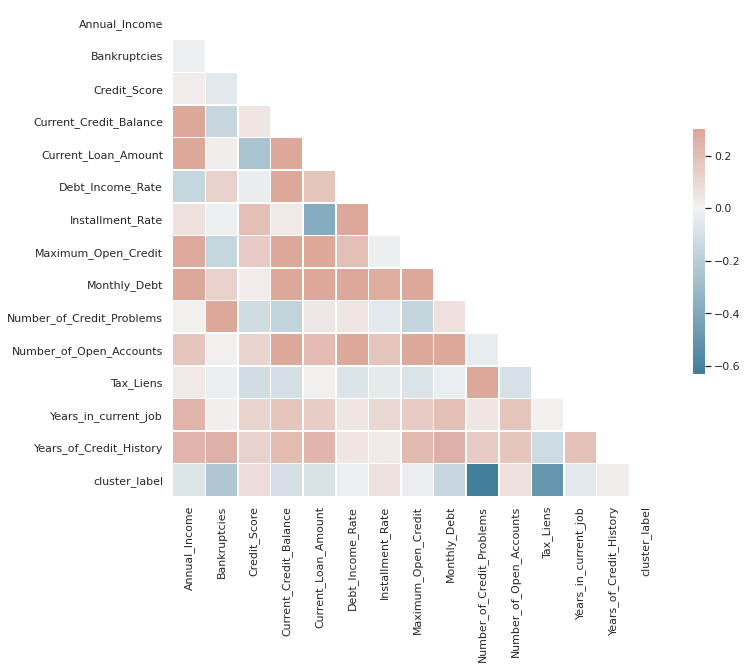

In [13]:
sns.set(style="white")

# Generate a large random dataset
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
#                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = pdf[columns_numerical].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 2.2.1 Line Charts of the Distribution of Values for the Numerical Attributes 

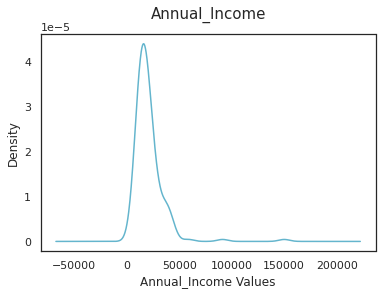

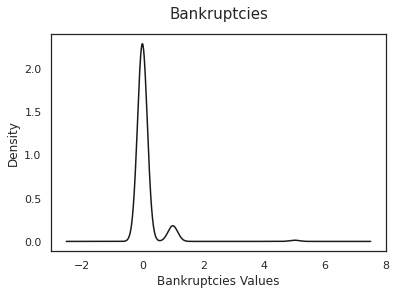

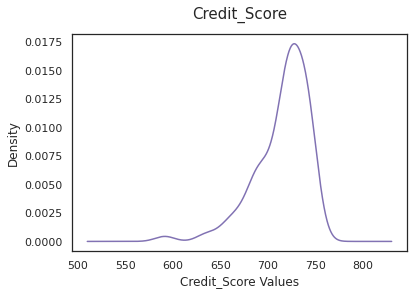

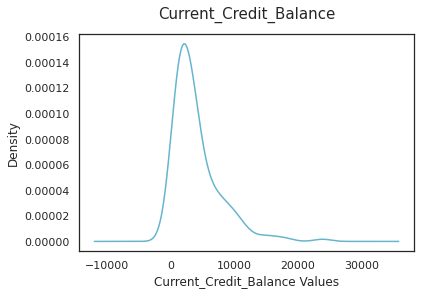

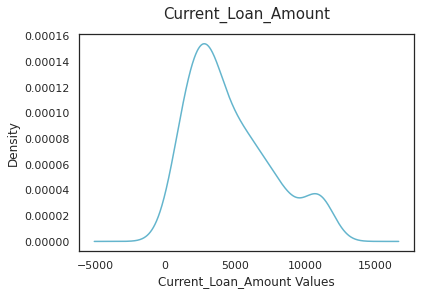

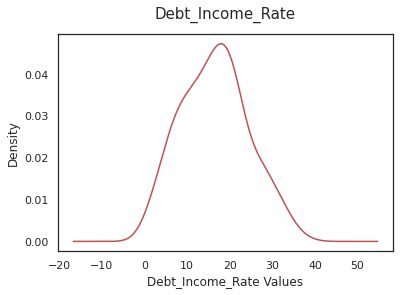

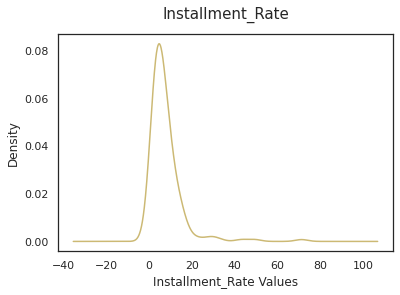

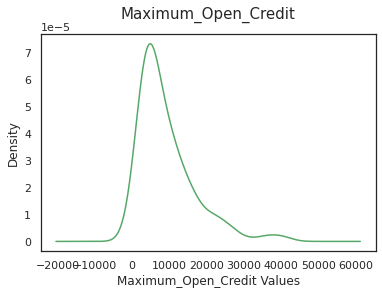

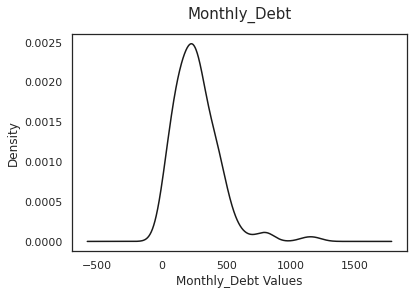

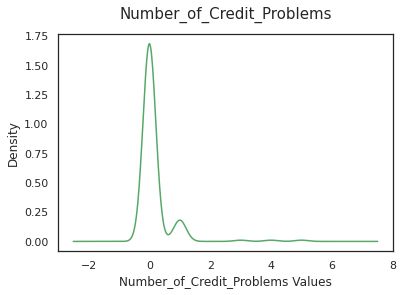

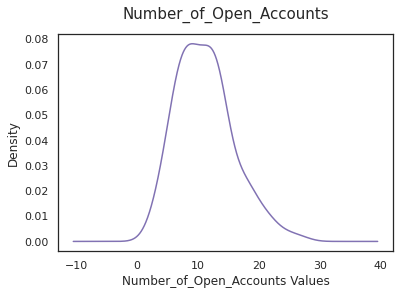

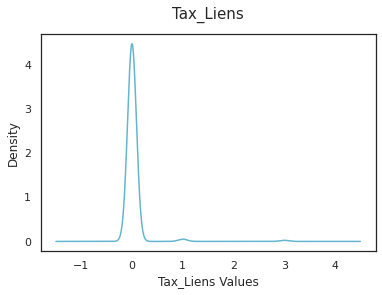

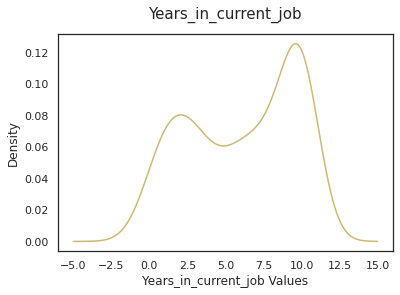

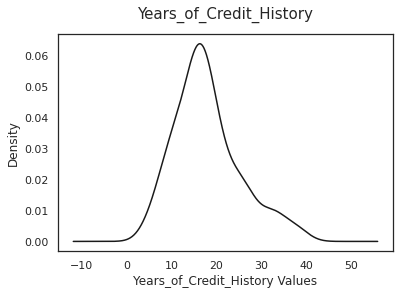

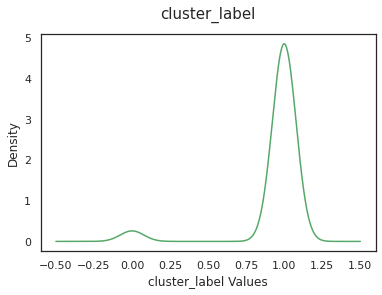

In [14]:
c=['b', 'g', 'r', 'c', 'm', 'y', 'k']

for col in columns_numerical:

        pdf[col].plot(kind='kde',color=random.choice(c))

        plt.title(col, pad=15, size=15)

        plt.xlabel(col + ' Values', size=12)

        plt.show()


### 2.2.2 Scatter Plots for the Numerical Attributes 

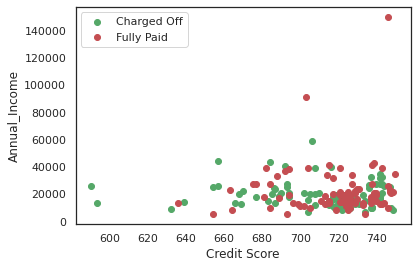

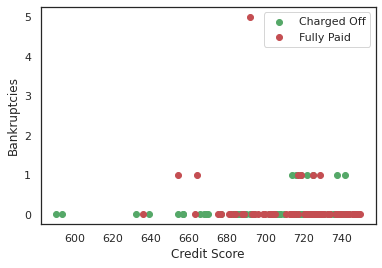

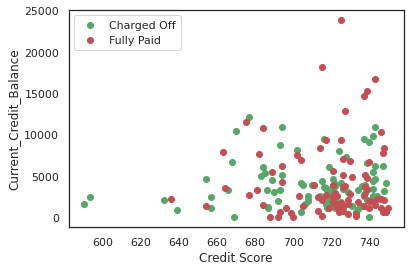

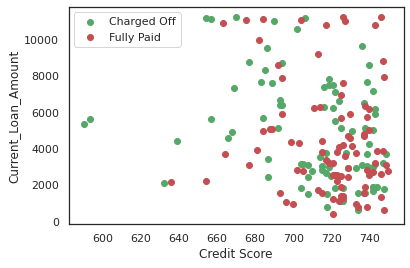

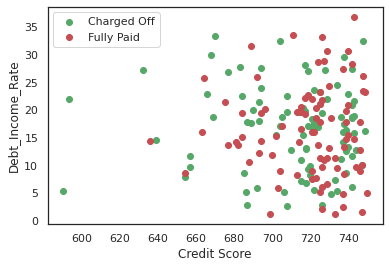

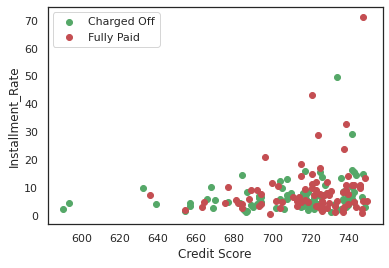

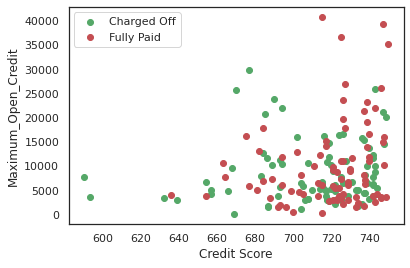

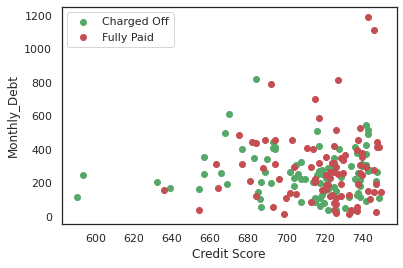

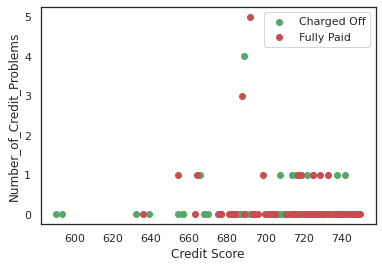

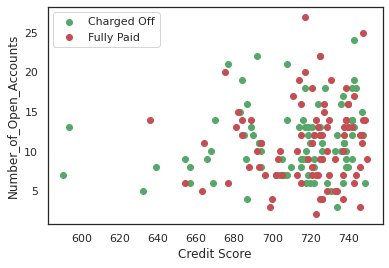

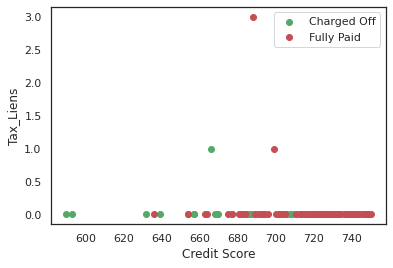

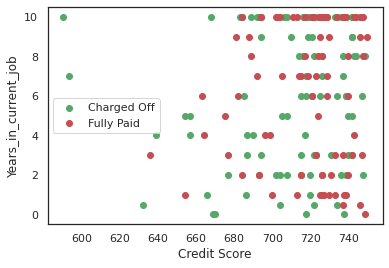

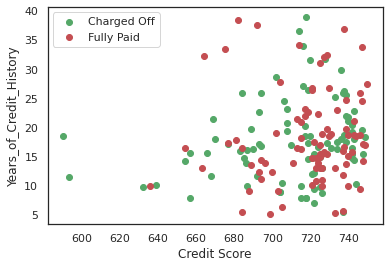

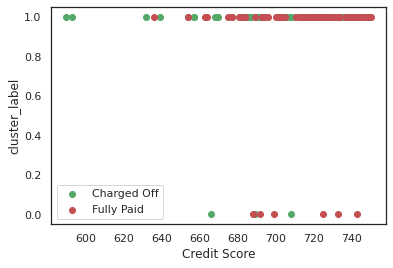

In [15]:

for col in columns_numerical:
        #print(col)
        if col!='Credit_Score':
           # print(col)
            
            plt.scatter(pdf[pdf['Loan_Status'] == 'Charged Off']['Credit_Score'], 
                        
                        pdf[pdf['Loan_Status'] == 'Charged Off'][col], color='g', label='Charged Off')
            
            plt.scatter(pdf[pdf['Loan_Status'] == 'Fully Paid']['Credit_Score'], 
                        
                        pdf[pdf['Loan_Status'] == 'Fully Paid'][col], color='r',label='Fully Paid')
            
            plt.xlabel('Credit Score')
            
            plt.ylabel(col)
            
            plt.legend()
            
            plt.show()


### Scatter Matrix

In [16]:
#eliminating categorical-in-appearance numerical attributes so that the scatter matrix is more representative
l=['Bankruptcies', 'Number_of_Credit_Problems','Tax_Liens','cluster_label', 'Years_in_current_job']
scatter_columns=[attr for attr in columns_numerical if attr not in l]


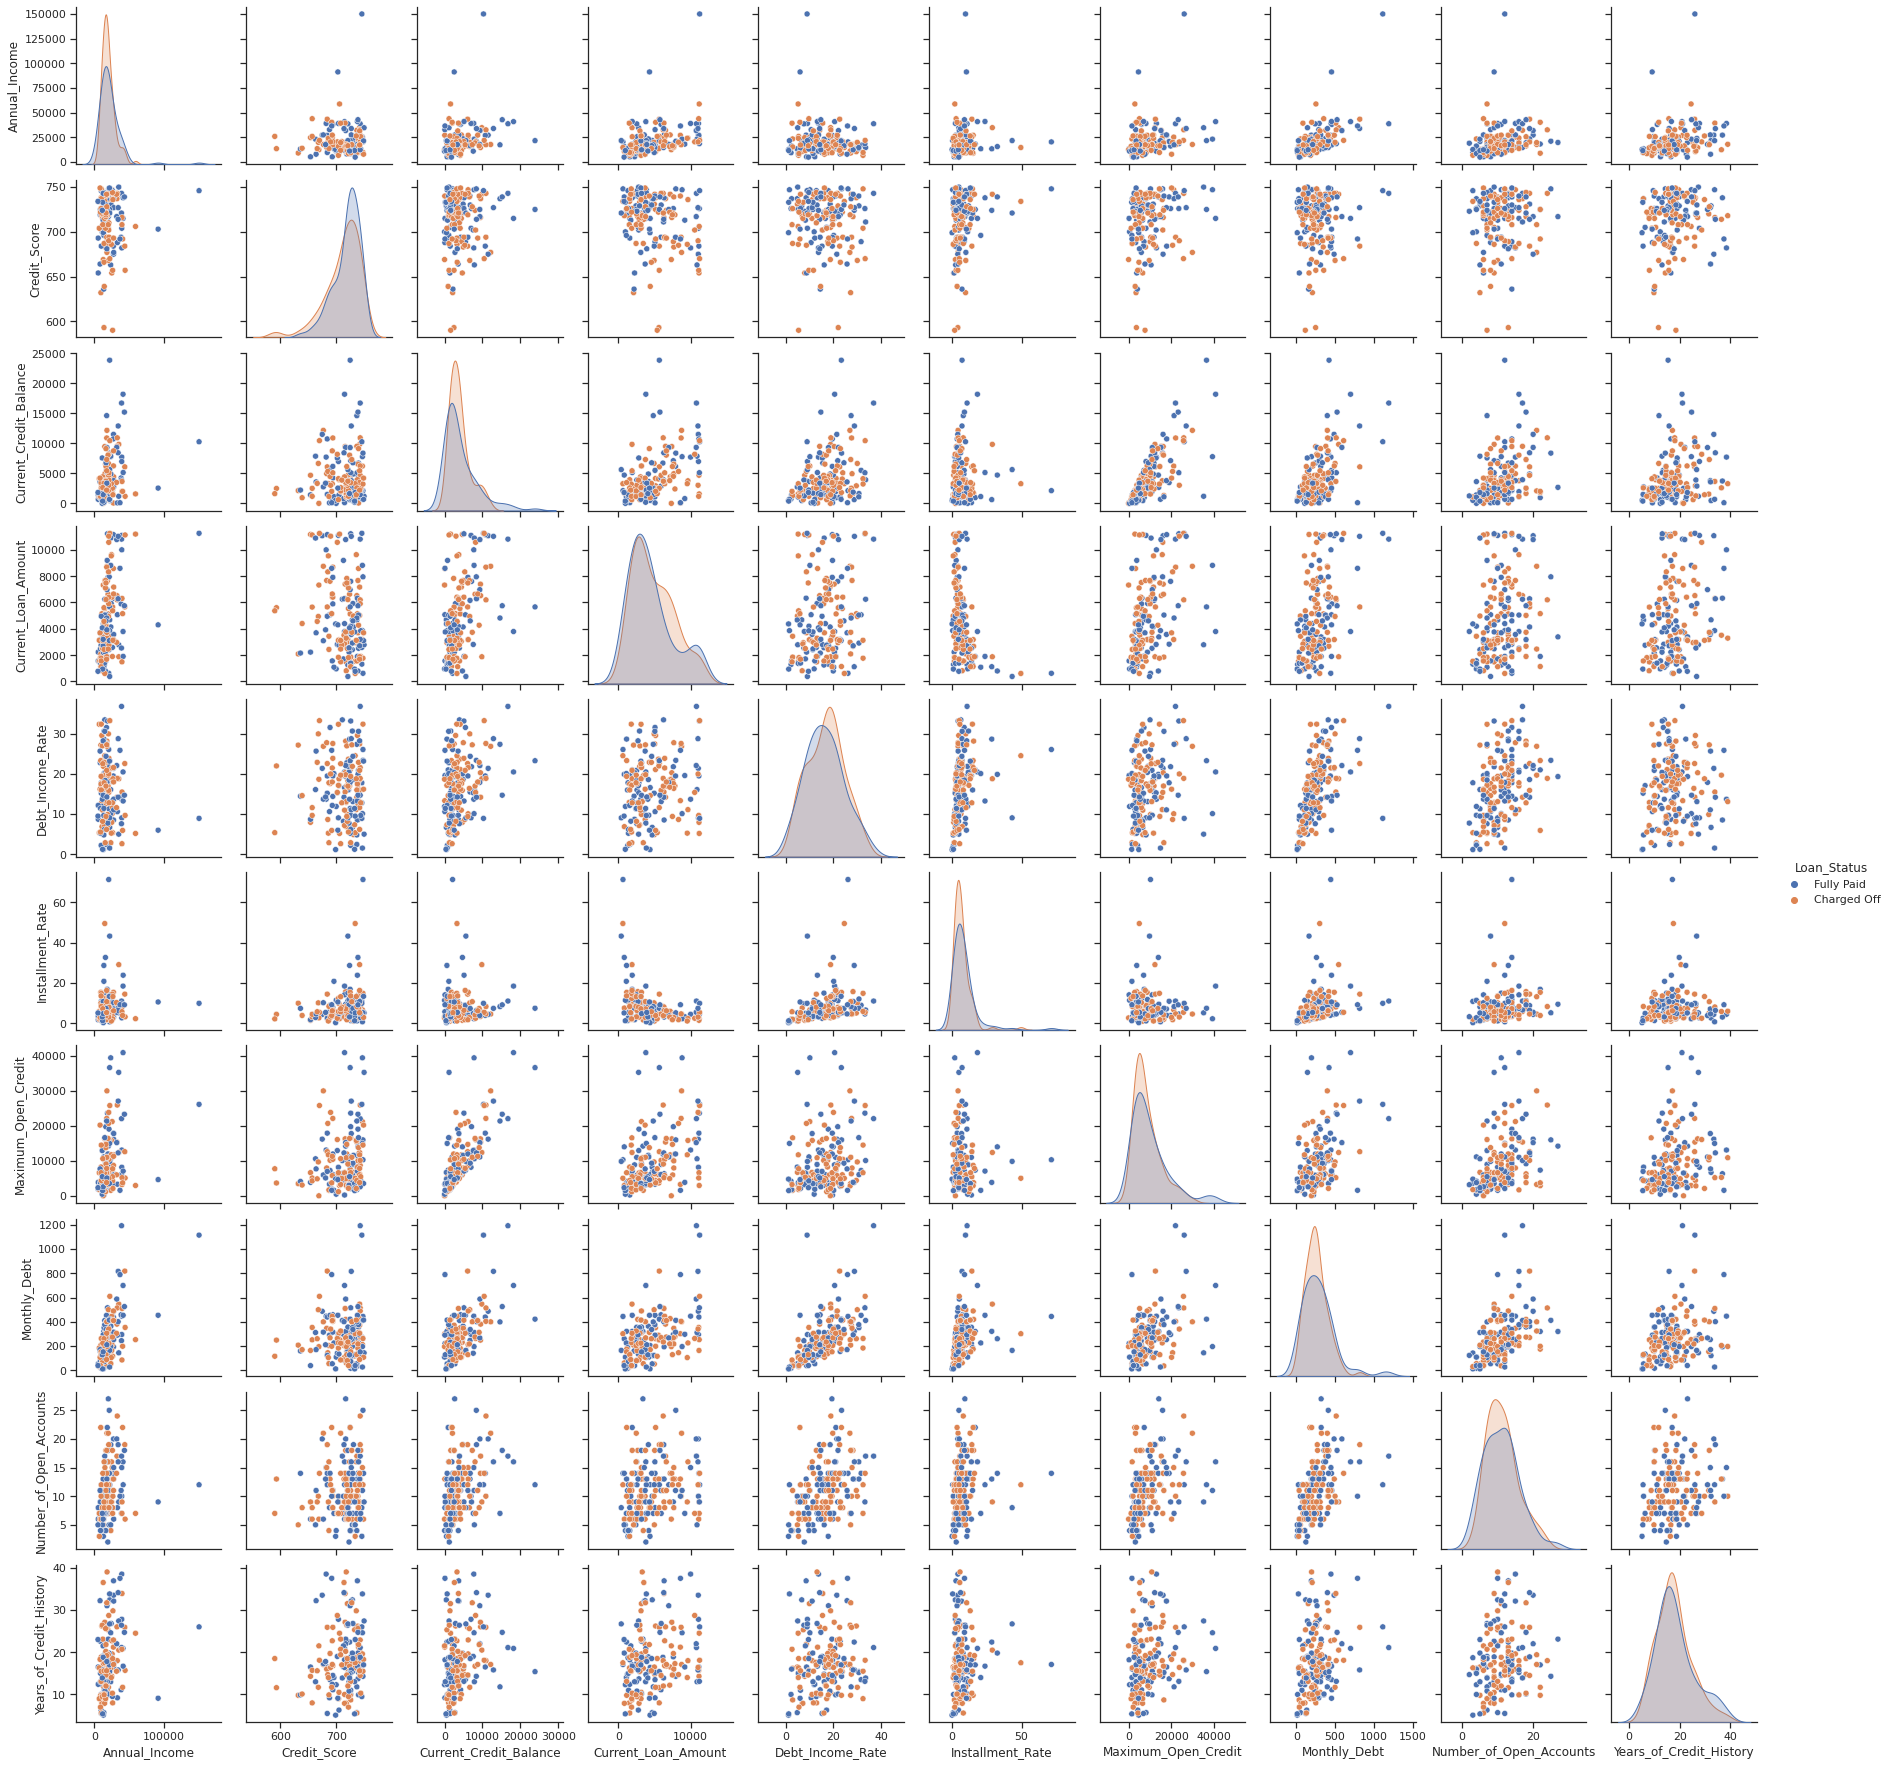

In [17]:
sns.set_theme(style="ticks")


a=sns.pairplot(pdf[scatter_columns+['Loan_Status']], hue="Loan_Status")

### 2.2.3 Bar Charts for the Categorical Attributes 

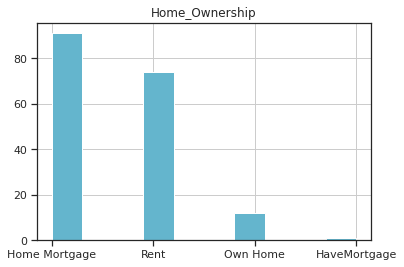

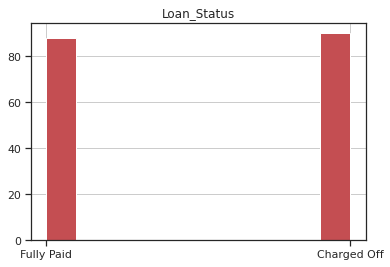

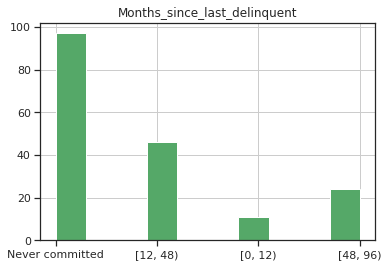

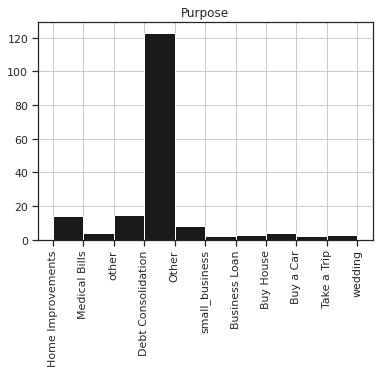

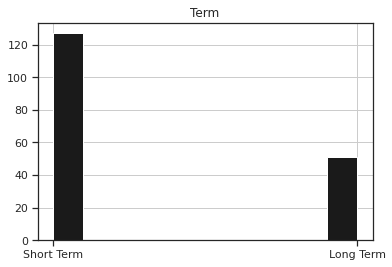

In [18]:
for col in (columns_categorical):
    
        pdf[col].hist(color=random.choice(c))
        
        plt.title(col)
        
        if pdf[col].nunique()>10:
            
            plt.xticks(rotation='vertical')
            
        plt.show()

In [19]:
#percentage of different types of home owners with regards to their Loan Status

pclass_xt = pd.crosstab(pdf['Home_Ownership'], pdf['Loan_Status'])

pclass_xt_pct = pclass_xt.div(pclass_xt.sum(1).astype(float), axis=0)

pclass_xt_pct

Loan_Status     Charged Off  Fully Paid
Home_Ownership                         
HaveMortgage       1.000000    0.000000
Home Mortgage      0.516484    0.483516
Own Home           0.250000    0.750000
Rent               0.527027    0.472973

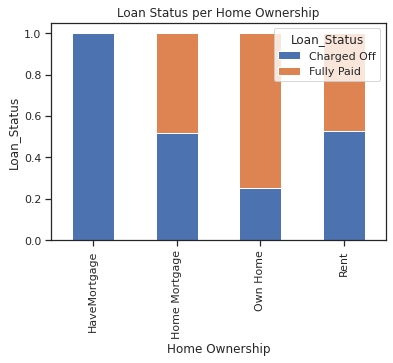

In [20]:
pclass_xt_pct.plot(kind='bar', stacked=True, 
                   title='Loan Status per Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Loan_Status')
plt.show()

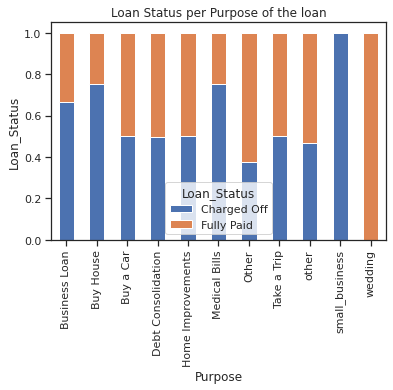

In [21]:
#percentage of different types of home owners with regards to their Loan Status

pclass_xt = pd.crosstab(pdf['Purpose'], pdf['Loan_Status'])

pclass_xt_pct = pclass_xt.div(pclass_xt.sum(1).astype(float), axis=0)

pclass_xt_pct.plot(kind='bar', stacked=True, 
                   title='Loan Status per Purpose of the loan')
plt.xlabel('Purpose')
plt.ylabel('Loan_Status')
plt.show()

### 2.2.4. Boxplot Analysis

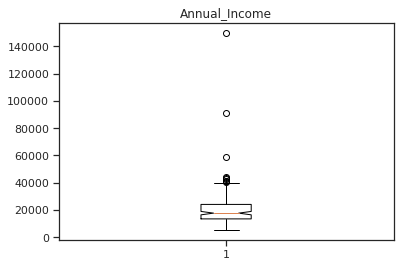

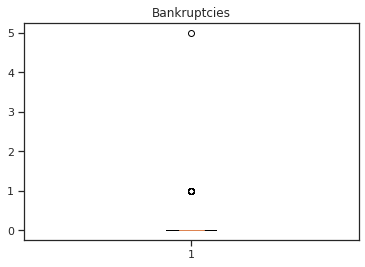

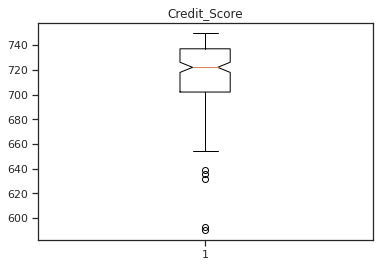

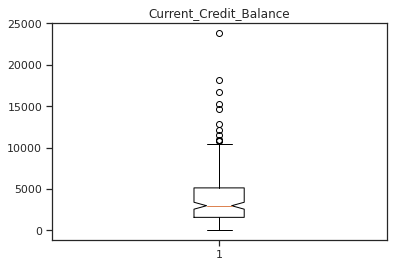

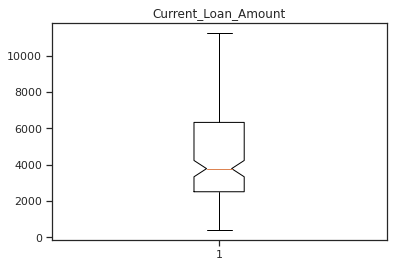

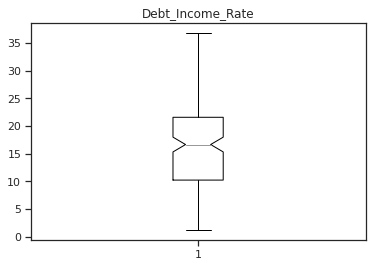

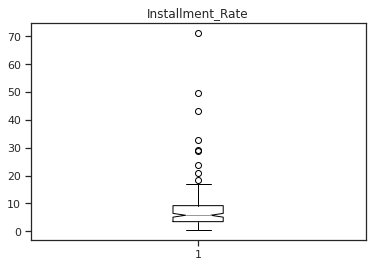

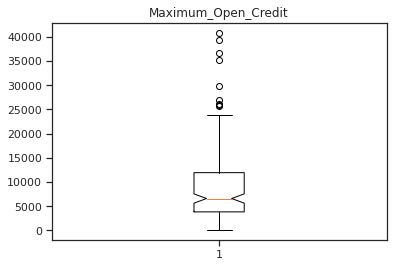

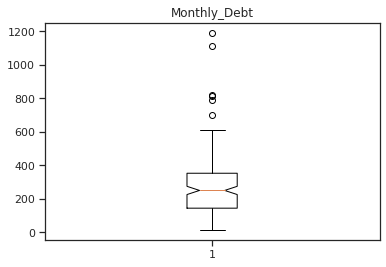

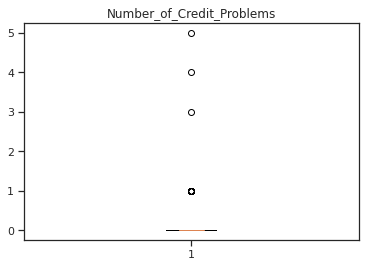

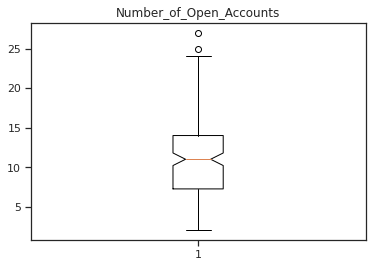

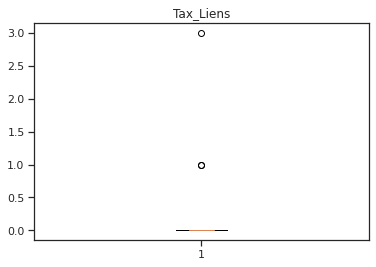

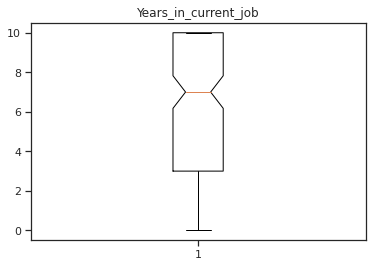

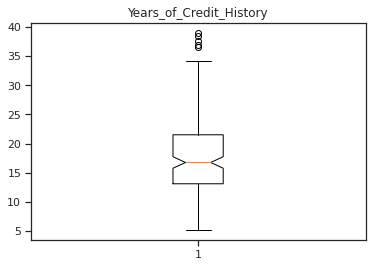

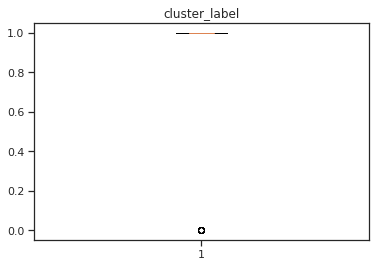

In [22]:
for col in columns_numerical:
    plt.boxplot(pdf[col], '#F7B5A6' )
    plt.title(col)
    plt.show()

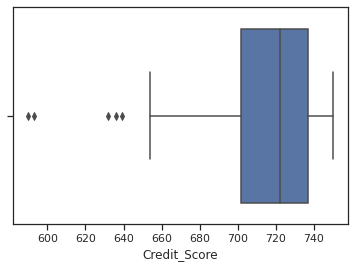

In [23]:
ax = sns.boxplot(x=pdf["Credit_Score"])

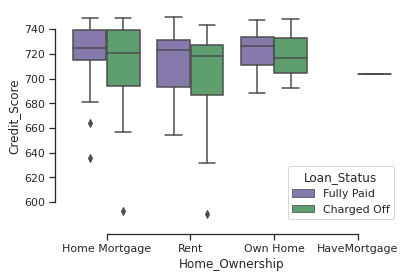

In [24]:
sns.boxplot(x="Home_Ownership",  y="Credit_Score",
            
            hue="Loan_Status", palette=["m", "g"],
            
            data=pdf)

sns.despine(offset=10, trim=True)
     

### 2.2.5. 3D Plots of interesting Feature Combinations in Matplotlib and Plotly.express

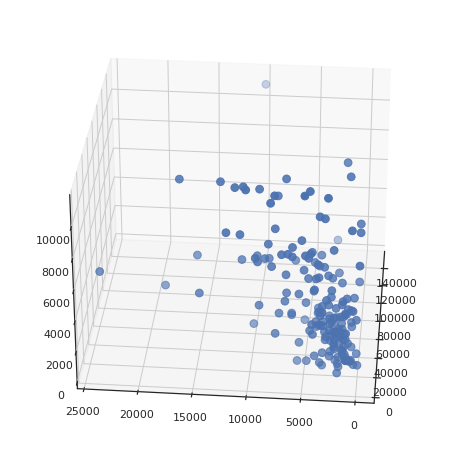

In [25]:
fig = plt.figure()

fig.set_size_inches(11.7, 8.27)

ax = fig.add_subplot( projection='3d')

cmap = ListedColormap(sns.color_palette("magma", 256).as_hex())

ax.scatter(pdf['Annual_Income'], pdf['Current_Credit_Balance'], pdf['Current_Loan_Amount'],cmap=plt.cm.viridis, s=60)

ax.view_init(30, 185)

plt.show()

Different libraries were used in order to plot insightful visual representations of the dataset. It is advised to install the plotly.express library and try rotating and zooming in and out of the 3D plot in order to get a better view of the data.

In [26]:
fig = px.scatter_3d(pdf, x=pdf['Annual_Income'], y=pdf['Current_Credit_Balance'], z=pdf['Current_Loan_Amount'], 
                    color=pdf['Loan_Status'],size=[0.01 for i in range (len(pdf))])

fig.show()

In [27]:
fig = px.scatter_3d(pdf, y=pdf['Annual_Income'], z=pdf['Current_Loan_Amount'], x=pdf['Credit_Score'], 
                    color=pdf['Loan_Status'], size=[0.01 for i in range (len(pdf))])
fig.show()

In [28]:
fig = px.scatter_3d(pdf, x=pdf['Annual_Income'], y=pdf['Maximum_Open_Credit'], z=pdf['Credit_Score'],
                    color=pdf['Loan_Status'], size=[0.01 for i in range (len(pdf))])
fig.show()

In [29]:
fig = px.scatter_3d(pdf, x=pdf['Current_Loan_Amount'], y=pdf['Maximum_Open_Credit'], z=pdf['Credit_Score'],
                    color=pdf['Home_Ownership'], size=[0.01 for i in range (len(pdf))])
fig.show()

----------------

# 3. Dimensionality Reduction

In [30]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics 
from pyspark.ml.linalg import Vector as MLVector, Vectors as MLVectors
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors
from pyspark.mllib.regression import  LabeledPoint


from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.clustering import GaussianMixture
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel

from mpl_toolkits.mplot3d import Axes3D  

import seaborn as sns
import numpy as np


----------------

## 3.1. PCA with Unsupervised Learning

In [31]:
numd=columns_numerical+ ['Loan_Status'] #numerical columns+dependent variable (Loan Status)

datas=sdf[numd] #spark numerical + loan status

datas.printSchema()

root
 |-- Annual_Income: long (nullable = true)
 |-- Bankruptcies: long (nullable = true)
 |-- Credit_Score: long (nullable = true)
 |-- Current_Credit_Balance: long (nullable = true)
 |-- Current_Loan_Amount: long (nullable = true)
 |-- Debt_Income_Rate: double (nullable = true)
 |-- Installment_Rate: double (nullable = true)
 |-- Maximum_Open_Credit: long (nullable = true)
 |-- Monthly_Debt: double (nullable = true)
 |-- Number_of_Credit_Problems: long (nullable = true)
 |-- Number_of_Open_Accounts: long (nullable = true)
 |-- Tax_Liens: long (nullable = true)
 |-- Years_in_current_job: double (nullable = true)
 |-- Years_of_Credit_History: double (nullable = true)
 |-- cluster_label: long (nullable = true)
 |-- Loan_Status: string (nullable = true)



In [32]:
datas = datas.withColumnRenamed("Loan_Status","label")

#vectorizing the numerical columns
assembler = VectorAssembler(
    inputCols=columns_numerical,
    outputCol="features")
output = assembler.transform(datas)

#normalization
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='std_features')
model = standardizer.fit(output)
output = model.transform(output)

indexer = StringIndexer(inputCol="label", outputCol="label_idx")
indexed = indexer.fit(output).transform(output)

sonar = indexed.select(['std_features', 'label', 'label_idx']) #extract only features of interest


sonar.show(n=3)

+--------------------+-----------+---------+
|        std_features|      label|label_idx|
+--------------------+-----------+---------+
|[-0.6984848819430...|Charged Off|      1.0|
|[-0.0221372276278...|Charged Off|      1.0|
|[2.80968230157373...| Fully Paid|      0.0|
+--------------------+-----------+---------+
only showing top 3 rows



1. Data Conversion
<br>
We will first fit a Gaussian Mixture Model with 2 components to the first 4 principal components of the data as an example of unsupervised learning. 

In [33]:
pca = PCA(k=4, inputCol="std_features", outputCol="pca")
model = pca.fit(sonar)
transformed = model.transform(sonar)

features = transformed.select('pca').rdd.map(lambda x: np.array(x))

2. gaussian mixture clustering on 4-component PCA

In [34]:
cluster_label = datas.select('cluster_label').rdd.map(lambda r: r[0]).collect()

labels = sonar.select('label_idx').rdd.map(lambda r: r[0]).collect()

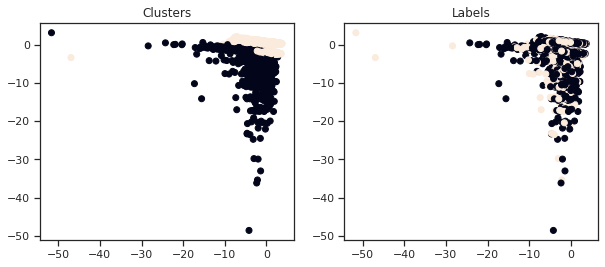

In [35]:
#comparing the cluster labels vs the original label (Loan Status) in the dataset
import matplotlib.pyplot as plt

xs = np.array(features.collect()).squeeze()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(xs[:, 0], xs[:,1], c=cluster_label,
 )
axes[0].set_title('Clusters')
axes[1].scatter(xs[:, 0], xs[:,1], c=labels)
axes[1].set_title('Labels')
pass

----------------

## 3.2. Visualizing two component PCA 

In [36]:
pca = PCA(k=2, inputCol="std_features", outputCol="pca")
model = pca.fit(sonar)
transformed = model.transform(sonar)

data=transformed.select('pca', 'label_idx')

data = transformed.rdd.map(lambda x: LabeledPoint(x[2], MLLibVectors.fromML(x[3]))) 

In [37]:
#Random Sampling for the sake of visualization at 2%


datas = data.sample(False, 0.02, 47) #sampled two component data

labels = datas.map(lambda x: x.label) #.label and .features are  methods of labeledpoint object!
features = datas.map(lambda x: x.features)

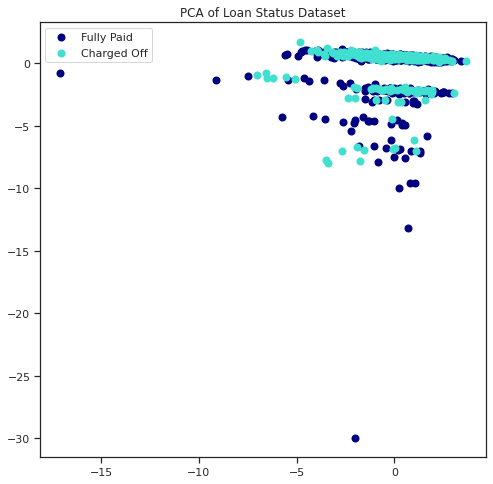

In [38]:
features=np.array(features.collect())
labels=np.array(labels.collect())

sa= np.column_stack((features, labels)) #sampled numpy array

colors = ['navy', 'turquoise']


plt.figure(figsize=(8, 8))
for color, i, target_name in zip(colors, [0, 1], [ 'Fully Paid', 'Charged Off']):
    plt.scatter(features[labels == i, 0], features[labels == i, 1],
                color=color, lw=2, label=target_name)
    plt.title('PCA of Loan Status Dataset')
plt.legend(loc="best", shadow=False, scatterpoints=1)
#plt.axis([-4, 4, -1.5, 1.5])

plt.show()

---------------------

## 3.3. Visualizing three component PCA 

In [39]:
pca = PCA(k=3, inputCol="std_features", outputCol="pca")
model = pca.fit(sonar)
transformed = model.transform(sonar)


data = transformed.rdd.map(lambda x: LabeledPoint(x[2], MLLibVectors.fromML(x[3]))) 
#first sample 0.2% of the dataset 
data = data.sample(False, 0.002, 47) #sampled two component data

labels = data.map(lambda x: x.label) #.label and .features are  methods of labeledpoint object!
features = data.map(lambda x: x.features)

features=np.array(features.collect())
labels=np.array(labels.collect())

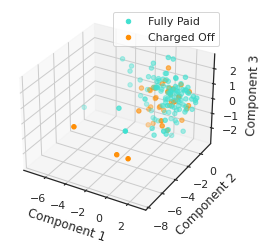

In [40]:
fig = plt.figure()
ax = fig.add_subplot( projection='3d')

# OUR ONE LINER ADDED HERE:
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1,1, 1, 1]))
#ax.scatter(features[:,1], features[:,2], features[:,0], c=labels, label=[ 'Fully Paid', 'Charged Off'])
colors = ['turquoise', 'darkorange']

for color, i, target_name in zip(colors, [0, 1], [ 'Fully Paid', 'Charged Off']):
    ax.scatter(features[labels == i, 0], features[labels == i, 1], features[labels == i, 2],
                color=color, lw=1, label=target_name)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.legend()




plt.show()